### 세상에 없는 얼굴 GAN 오토인코더 

In [7]:
# 배치 정규화 , 이미지 확대 ,DCGAN
import random


import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Dense, Dropout, Flatten, Input, LeakyReLU,
                                     Reshape, UpSampling2D)
from tensorflow.keras.models import Model, Sequential

In [8]:
# (x_train,y_train), (x_test,y_test) = mnist.load_data()

In [9]:
# 생성자 모델 생성
generator=Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # 입력층 ->layer 1
generator.add(BatchNormalization()) # 배치 정규화 : 평균이 0, 분산이 1인 데이터로 재배치
generator.add(Reshape((7, 7, 128))) # 3차원으로 데이터 타입 변경
generator.add(UpSampling2D(size=(2, 2))) # 이미지를 2배로 확장시킴 14*14 128
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same',activation='tanh'))
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_2 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)      

In [10]:
# 반별자 모델 생성
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5,strides=2,
                         input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5,strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.summary()

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False #학습하지않음


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_2 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_3 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [11]:

#생성자와 판별자 모델을 연결시켜서 gan 모델을 생성
ginput= Input(shape=(100,))
dis_output= discriminator(generator(ginput))
gan=Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [22]:
def gan_train(epoch,batch_size,saving_interval):
    #MNIST 에서 실제 이미지를 가져옴
    (x_train,_),(_,_)=mnist.load_data()
    x_train=x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
    ## -1 에1 사이의 수를 정규화 
    x_train=(x_train-127.5)/127.5
    
    true=np.ones((batch_size,1)) #true false target 데이터 선정할떄 좋을거같다. 
    fake=np.zeros((batch_size,1))
    
    for i in range(epoch):
        #실제 데이터를 판별자에 입력
        idx=np.random.randint(0,x_train.shape[0],batch_size)
        imgs=x_train[idx] # 랜덤으로 실제 이미지를 가져옴
        d_loss_real=discriminator.train_on_batch(imgs,true) #실제 이미지의 loss 값
        
        #가상 데이터(이미지)를 판별자에 입력
        noise=np.random.normal(0,1,(batch_size,100))
        gen_imgs=generator.predict(noise)
        d_loss_fake=discriminator.train_on_batch(gen_imgs,fake) #실제 이미지의 loss 값
        
        #판별자와 생성자의 오차 계산
        d_loss=np.add(d_loss_real,d_loss_fake)*0.5
        g_loss=gan.train_on_batch(noise,fake)
        
        print("Epoch:{:.4f}, d_loss:{:.4f}, g_loss:{:.4f}".format(epoch,d_loss,g_loss))
        
        if i % saving_interval == 0:
            noise=np.random.normal(0,1,(25,100))
            
            gen_imgs=0.5 * gen_imgs + 0.5
            
            fig,axs=plt.subplots(5,5)
            count=0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count,:,:,0],cmap='Greys')
                    axs[j,k].axis('off')
                    count += 1
                fig.savefig('./data/gan_images/gan_mnist_{:d}.png'.format(i))

In [13]:
# #함수 테스트 하기
# batch_size = 10
# epoch=10
# (x_train,_),(_,_)=mnist.load_data()
# x_train=x_train.reshape(x_train.shape[0],28,28,1).astype('float32')

# ## -1 에1 사이의 수를 정규화 
# x_train=(x_train-127.5)/127.5

# true=np.ones((batch_size,1)) #true false target 데이터 선정할떄 좋을거같다. 
# fake=np.zeros((batch_size,1))

# for i in range(epoch):
#     #실제 데이터를 판별자에 입력
#     idx=np.random.randint(0,x_train.shape[0],batch_size)
#     imgs=x_train[idx]
#     d_loss_real=discriminator.train_on_batch(imgs,true) #실제 이미지의 라벨을 가져옴
    
#      #가상 데이터(이미지)를 판별자에 입력
#     noise=np.random.normal(0,1,(batch_size,100))
#     gen_imgs=generator.predict(noise)
#     d_loss_fake=discriminator.train_on_batch(gen_imgs,fake) #실제 이미지의 loss 값
# true
# idx
# discriminator.train_on_batch(gen_imgs,fake) 

In [26]:
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./data/gan_images/gan_mnist_final%d.png" % i)

1/1 [==============================] - 0s 150ms/step
epoch:0  d_loss:0.2201  g_loss:2.9747
1/1 [==============================] - 0s 120ms/step
epoch:1  d_loss:0.2275  g_loss:2.8492
1/1 [==============================] - 0s 122ms/step
epoch:2  d_loss:0.3206  g_loss:3.1967
1/1 [==============================] - 0s 126ms/step
epoch:3  d_loss:0.1869  g_loss:3.8097
1/1 [==============================] - 0s 127ms/step
epoch:4  d_loss:0.1600  g_loss:3.9090
1/1 [==============================] - 0s 131ms/step
epoch:5  d_loss:0.3842  g_loss:4.1521
1/1 [==============================] - 0s 127ms/step
epoch:6  d_loss:0.4022  g_loss:3.5176
1/1 [==============================] - 0s 128ms/step
epoch:7  d_loss:0.4359  g_loss:2.9556
1/1 [==============================] - 0s 122ms/step
epoch:8  d_loss:0.2098  g_loss:3.6223
1/1 [==============================] - 0s 129ms/step
epoch:9  d_loss:0.1613  g_loss:4.0508
1/1 [==============================] - 0s 124ms/step
epoch:10  d_loss:0.3881  g_loss:3.181

KeyboardInterrupt: 

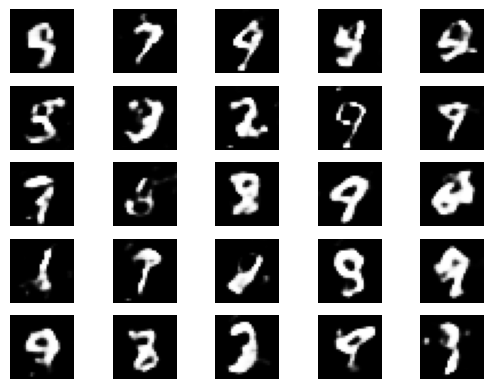

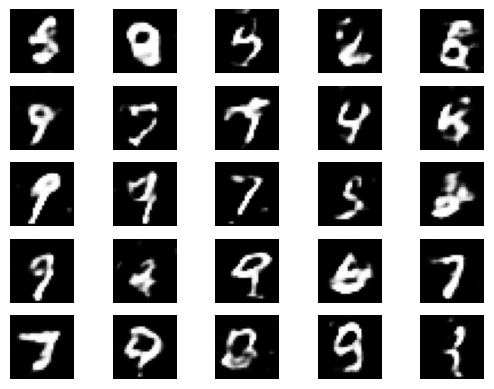

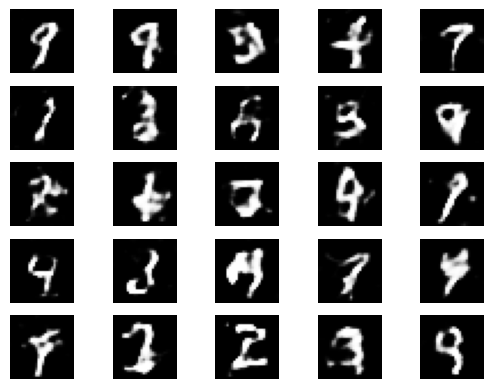

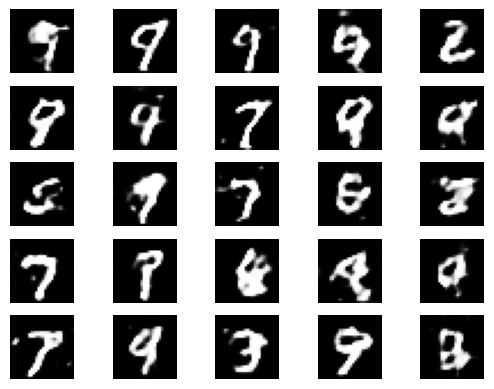

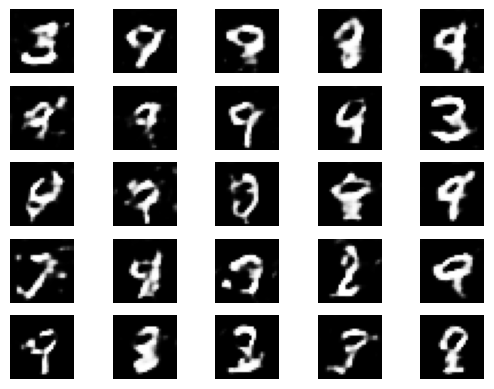

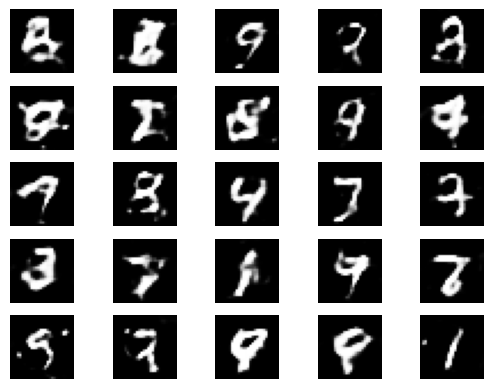

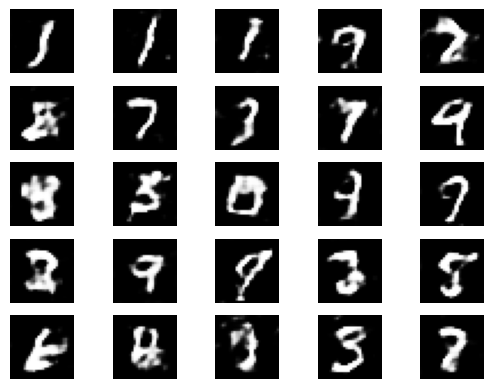

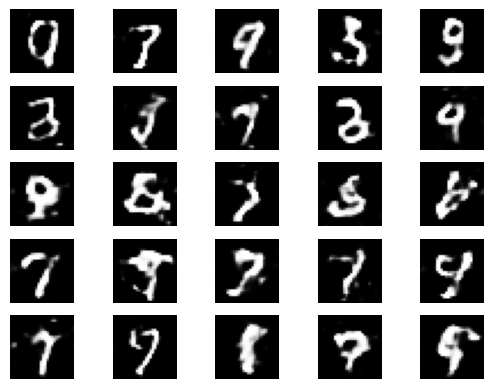

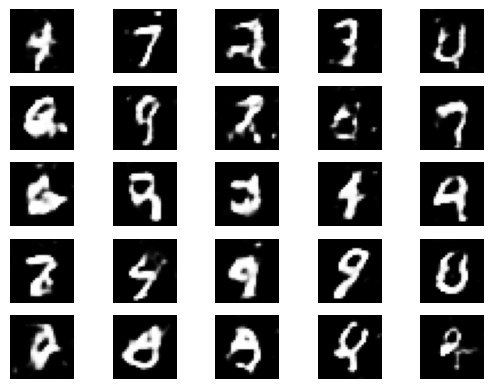

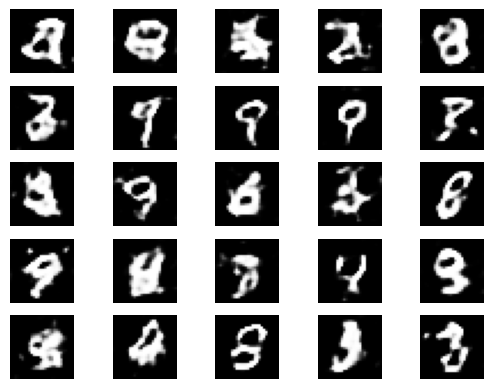

In [28]:
gan_train(5001,32,100)

In [ ]:
print(input())